In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# pd.set_option('display.max_colwidth', 150000) # view everything
import sys
sys.path.insert(1, '../')
import research
from research import nlp_eda
import re
import pickle 
import pyLDAvis
import os
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from pprint import pprint


/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Table of Contents
* [LDA](#lda)
    * [LDA Model Training](#lda-model-training)
    *  [Analyzing the LDA Model](#analyzing-lda)
    * [Getting the Most Representative Sentence for Each Topic](#representative)
    * [Frequency Distribution of Word Counts in the Documents](#frequency-dist)
    * [Word Counts of Topic Keywords](#topic-keywords)
    * [t-SNE](#tsne)
    * [pyLDAvis](#pyldavis)
* [Non Negative Matrix Factorization](#nmf)
    

In [56]:
paths = {'all_data': '../data/merged_df.csv'}
all_data = pd.read_csv(paths['all_data'], index_col = 0)

all_data.head()

Description  Location       Job Title
0  \n\n\nThis position can be based remotely anyw...  new york  data scientist
1  \n\nSummary\n \nImagine what you could do here...     texas  data scientist
2  \nLead analytics and measurement efforts for s...     other  data scientist
3  \nAbout Gusto\n\nGusto is a modern, online peo...     other  data scientist
4  \n\nSummary\n \nAt Apple, new ideas have a way...     texas  data scientist

In [68]:
ds = all_data[all_data["Job Title"] == 'data scientist']

ds['Description'].iloc[0].replace("\n", " ")

"   This position can be based remotely anywhere in the USA,\xa0or based in Tonawanda, NY.  Linde is a leading global industrial gases and engineering company with 2019 sales of $28 billion (€25 billion). We live our mission of making our world more productive every day by providing high-quality solutions, technologies and services which are making our customers more successful and helping to sustain and protect our planet.  The company serves a variety of end markets including aerospace, chemicals, food and beverage, electronics, energy, healthcare, manufacturing and primary metals. Linde's industrial gases are used in countless applications, from life-saving oxygen for hospitals to high-purity & specialty gases for electronics manufacturing, hydrogen for clean fuels and much more. Linde also delivers state-of-the-art gas processing solutions to support customer expansion, efficiency improvements and emissions reductions.  For more information about the company and its products and se

In [60]:
def preprocess(seq):
    ''' Preprocessing pipeline '''
    
    # Removing particular tokens
    remove_words = ['analyst', ]
    
    # Removing punctuation
    seq = seq.map(lambda x: re.sub('[,\.!?]', '', x))
    
    # Converting to lowercase
    seq = seq.map(lambda x: x.lower())
    
    # Removing all of the \n
    seq = seq.replace("\n", " ")
    
    return seq

In [61]:
# Subsetting into data scientist vs data analyst
ds = all_data[all_data["Job Title"] == 'data scientist']
da = all_data[all_data["Job Title"] == 'data analyst']

# Creating an object where my NLP EDA functions are located
nlp = nlp_eda()


# Applying preprocess function
ds = preprocess(ds['Description'])

In [62]:
ds

0      \n\n\nthis position can be based remotely anyw...
1      \n\nsummary\n \nimagine what you could do here...
2      \nlead analytics and measurement efforts for s...
3      \nabout gusto\n\ngusto is a modern, online peo...
4      \n\nsummary\n \nat apple, new ideas have a way...
                             ...                        
317    description\nsentient energy - a koch engineer...
349    truveris is a leading digital health company f...
354    job summary\nresponsible for leveraging intern...
361    businesses raytheon technologies corporate\njo...
57     wes is looking for a bi analyst / data scienti...
Name: Description, Length: 457, dtype: object

In [15]:
# help(a)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


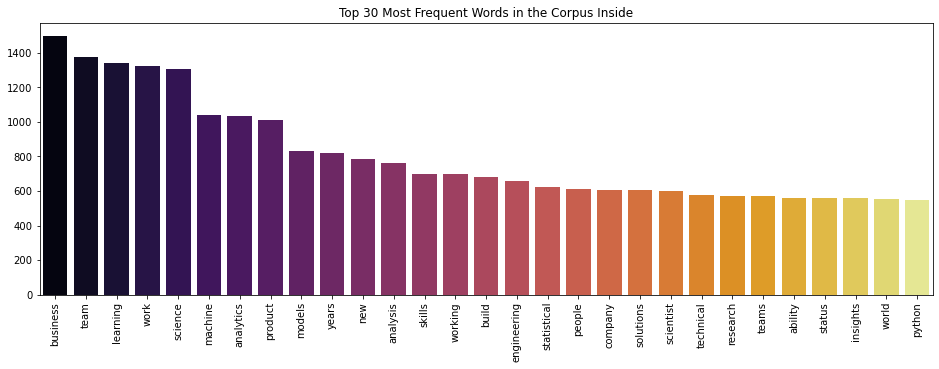

In [16]:
# Visualizing the descriptions of my data
nlp.visualize_counts(ds)

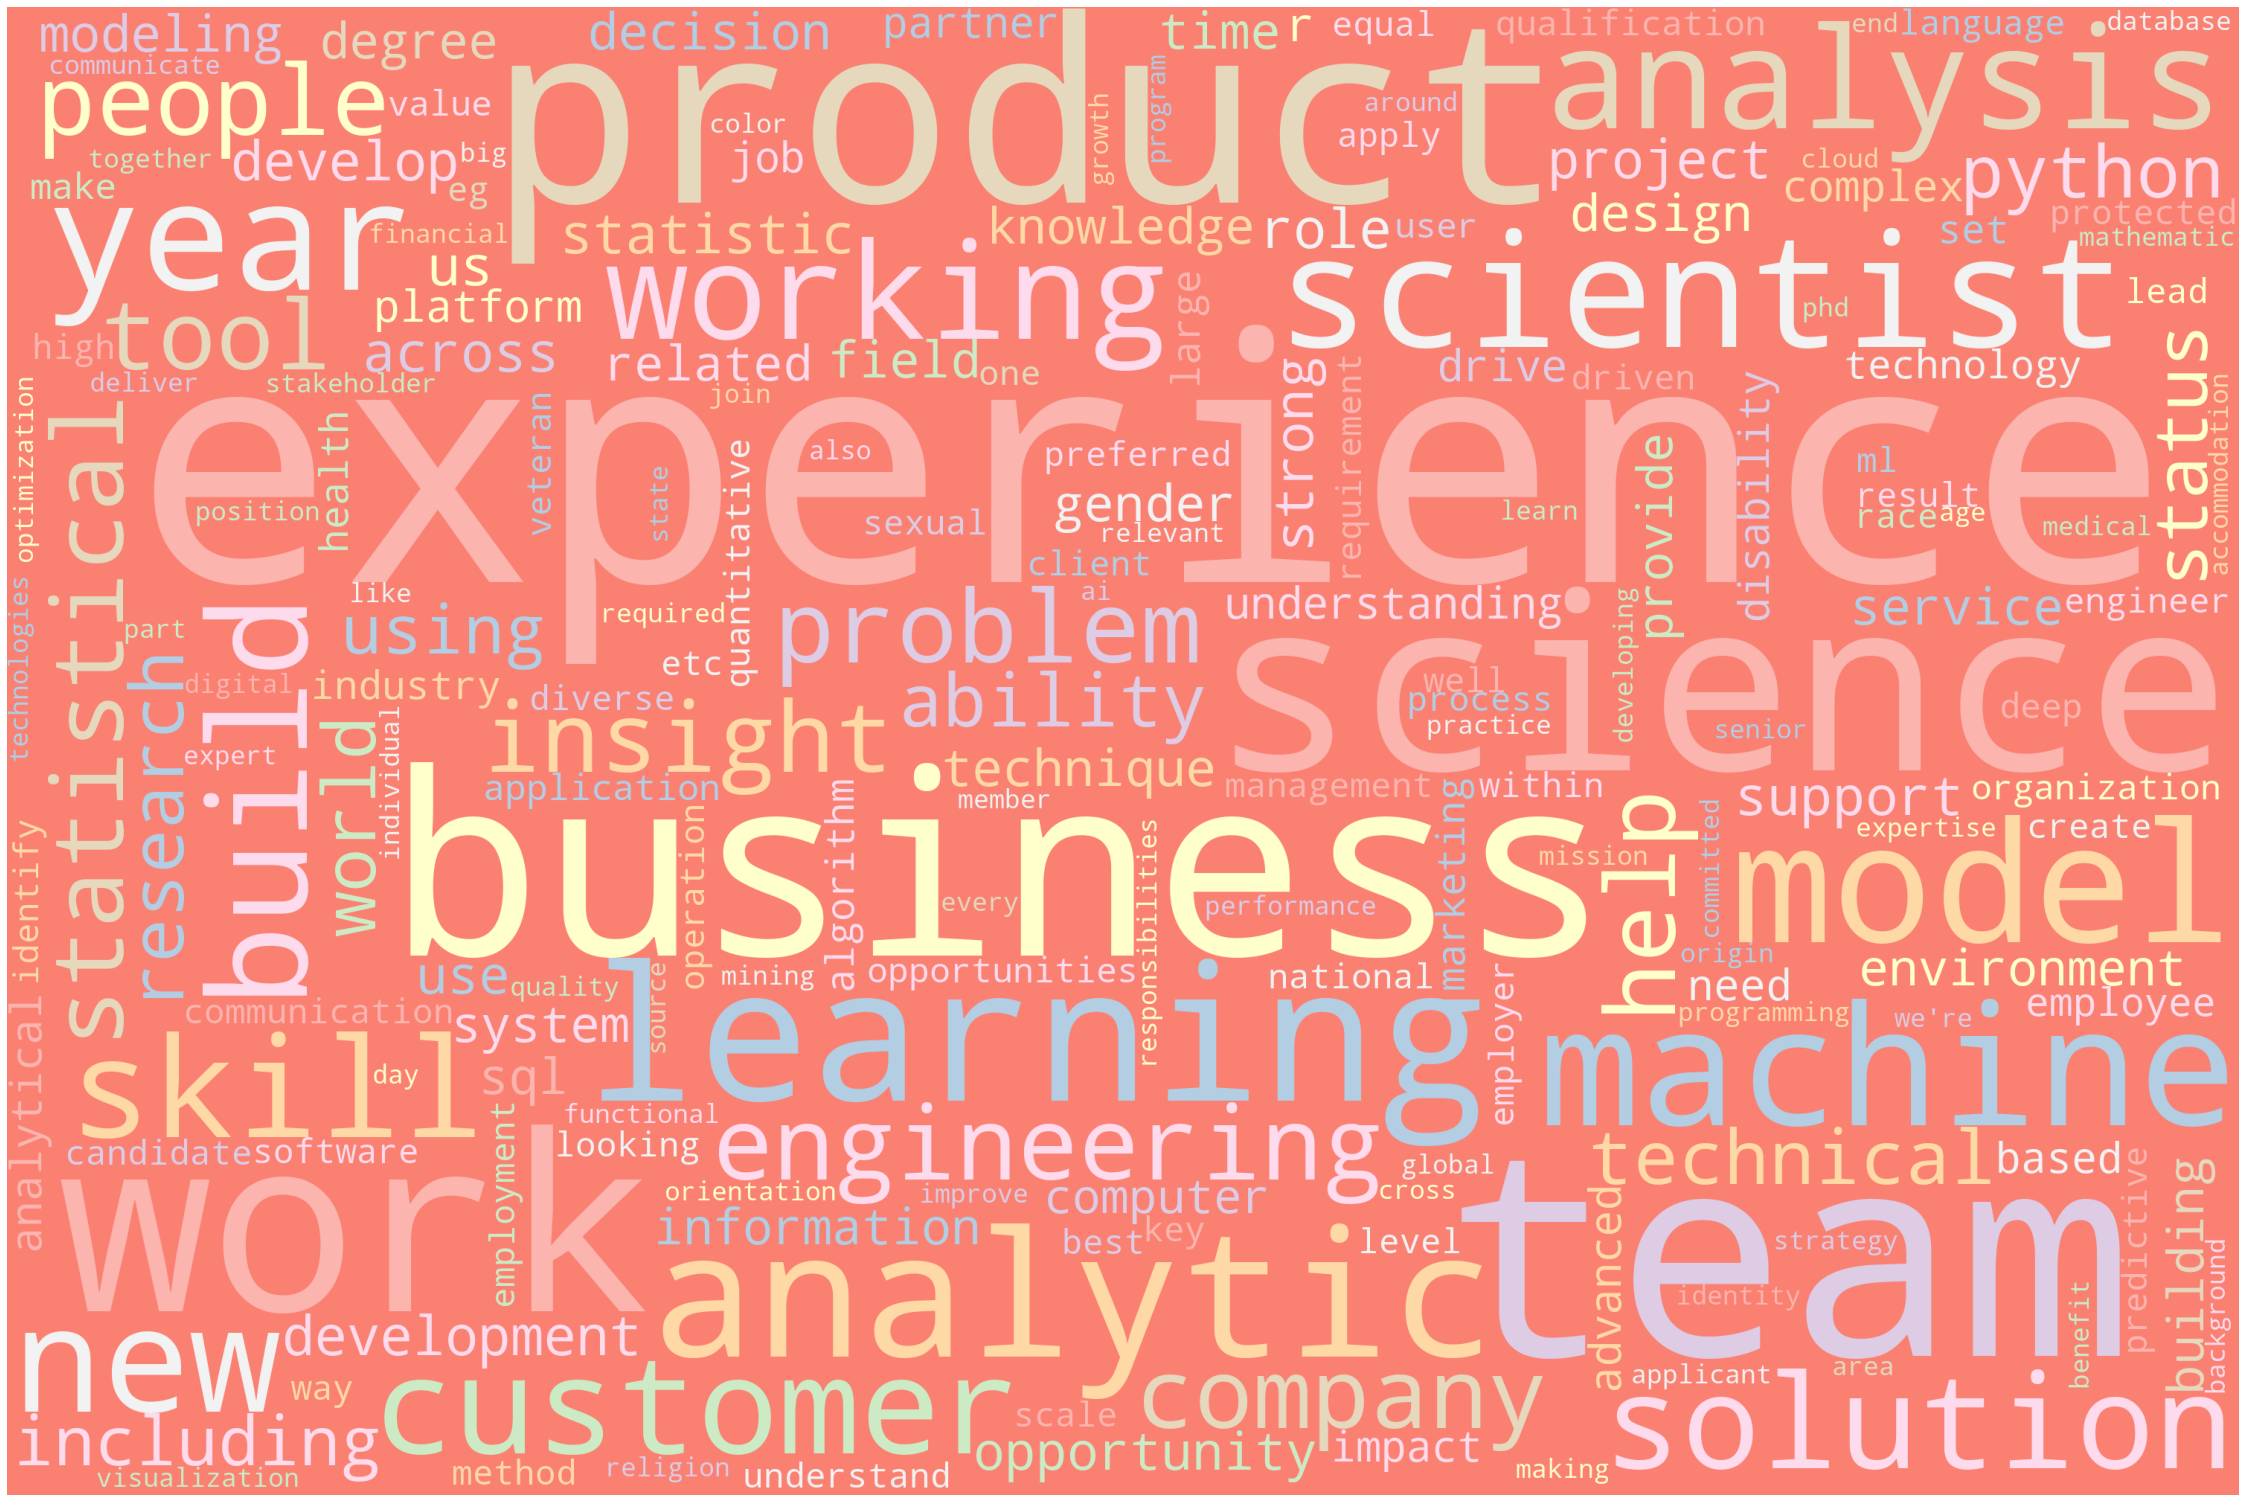

In [17]:
nlp.word_cloud(ds)

In [18]:
bow = nlp.to_wcdf(ds)

In [19]:
bow.head()

00  10  100  10000  100000  1100  12  13  15  15000  ...  write  writes  \
0   0   0    0      0       0     0   0   0   0      0  ...      0       0   
1   0   0    0      0       0     0   0   0   0      0  ...      0       0   
2   0   0    0      0       0     0   0   0   0      0  ...      0       0   
3   0   0    0      0       2     0   0   0   0      0  ...      0       0   
4   0   0    0      0       0     0   0   0   0      0  ...      0       0   

   writing  written  year  years  yes  yet  yield  york  
0        0        0     0      1    0    0      0     0  
1        0        0     0      1    0    0      0     0  
2        0        0     0      1    0    0      0     0  
3        0        0     0      3    0    0      0     2  
4        0        0     0      0    0    0      0     0  

[5 rows x 3412 columns]

# LDA <a name="lda"></a>

Helpful articles: [1](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2), [2](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158), [3](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

Note: A lot of the content here is paraphrased from source 2 above

And the goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those imaginary topics.

We want to solve:

$$
P(\theta_{1:M}, z_{1:M}, \beta_{1:K}|D:\alpha_{1:M},\eta_{1:k})
$$

This is just saying:

    I have a set of M documents, each document having N words, where each word is generated by a single topic from a set of K topics. I’m looking for the joint posterior probability of


Each document can be described by a distribution of topics and each topic can be described by a distribution of word



$\theta$ (distributional parameter) or $P(\text{topic } t|\text{document } d)$: 
_The proportion of words in document d that are assigned to topic t. This tries to capture how many words belong to topic t for a given document d excluding the current word. If a lot of words from d belong to t, there is a higher probability that word w belongs to t._

Next we have:

$\beta$ (distributional parameter) or $P(\text{word } w|\text{topic } t)$: _The proportion of assignments to topic t over all documents that come from this word w. This tries to capture how many documents are in topic t because of the word w._

* k — Number of topics a document belongs to (a fixed number)
* V — Size of the vocabulary
* M — Number of documents
* N — Number of words in each document
* w — A word in a document. This is represented as a one hot encoded vector of size V (i.e. V — vocabulary size)
* w (bold w): represents a document (i.e. vector of “w”s) of N words
* D — Corpus, a collection of M documents
* z — A topic from a set of k topics. A topic is a distribution words. For example it might be, Animal = (0.3 Cats, 0.4 Dogs, 0 AI, 0.2 Loyal, 0.1 Evil)


One of the way to solve this is through a Variational Inference optimization problem!

For this research project, I will be referencing [this](https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb) implementation.

In [20]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','data'])


In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
              
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
         if word not in stop_words] for doc in texts]

In [22]:
data = ds.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)


In [23]:
data_words

[['position',
  'based',
  'remotely',
  'anywhere',
  'usa',
  'based',
  'tonawanda',
  'ny',
  'linde',
  'leading',
  'global',
  'industrial',
  'gases',
  'engineering',
  'company',
  'sales',
  'billion',
  'billion',
  'live',
  'mission',
  'making',
  'world',
  'productive',
  'every',
  'day',
  'providing',
  'high',
  'quality',
  'solutions',
  'technologies',
  'services',
  'making',
  'customers',
  'successful',
  'helping',
  'sustain',
  'protect',
  'planet',
  'company',
  'serves',
  'variety',
  'end',
  'markets',
  'including',
  'aerospace',
  'chemicals',
  'food',
  'beverage',
  'electronics',
  'energy',
  'healthcare',
  'manufacturing',
  'primary',
  'metals',
  'linde',
  'industrial',
  'gases',
  'used',
  'countless',
  'applications',
  'life',
  'saving',
  'oxygen',
  'hospitals',
  'high',
  'purity',
  'specialty',
  'gases',
  'electronics',
  'manufacturing',
  'hydrogen',
  'clean',
  'fuels',
  'much',
  'linde',
  'also',
  'delivers',


In [24]:

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 4), (28, 2), (29, 1)]


## Now we want to do the LDA model training <a name="lda-model-training"></a>

In [25]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"experience" + 0.009*"business" + 0.008*"science" + 0.007*"work" + '
  '0.006*"team" + 0.006*"learning" + 0.005*"product" + 0.005*"insights" + '
  '0.005*"years" + 0.005*"engineering"'),
 (1,
  '0.017*"experience" + 0.009*"work" + 0.008*"learning" + 0.007*"science" + '
  '0.007*"team" + 0.006*"product" + 0.006*"business" + 0.006*"machine" + '
  '0.005*"new" + 0.005*"analytics"'),
 (2,
  '0.012*"experience" + 0.007*"business" + 0.007*"learning" + 0.007*"science" '
  '+ 0.007*"team" + 0.006*"work" + 0.005*"models" + 0.005*"machine" + '
  '0.005*"product" + 0.005*"company"'),
 (3,
  '0.014*"experience" + 0.011*"business" + 0.010*"science" + 0.008*"team" + '
  '0.007*"analytics" + 0.006*"learning" + 0.006*"work" + 0.006*"machine" + '
  '0.005*"models" + 0.004*"skills"'),
 (4,
  '0.012*"experience" + 0.009*"business" + 0.008*"learning" + 0.007*"work" + '
  '0.006*"machine" + 0.006*"science" + 0.006*"analytics" + 0.005*"team" + '
  '0.005*"product" + 0.004*"years"'),
 (5,
  '0.

## Analyzing the LDA model <a name="analyzing-lda"></a>
We are now going to visualize the topics for intepretability.

In [26]:
# dir(lda_model)

In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus, 
            texts=data):
    # Initialize output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution 
        # and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for 
                                            word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4),
                               topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    # Formatting
    # Format
    sent_topics_df = sent_topics_df.reset_index()
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
    return(sent_topics_df)

In [28]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

In [29]:
df_topic_sents_keywords

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             3.0              0.6480   
1              1             9.0              0.9230   
2              2             8.0              0.9976   
3              3             6.0              0.7478   
4              4             9.0              0.5714   
..           ...             ...                 ...   
452          452             3.0              0.7603   
453          453             2.0              0.3098   
454          454             9.0              0.9237   
455          455             5.0              0.8861   
456          456             6.0              0.4569   

                                              Keywords  \
0    experience, business, science, team, analytics...   
1    experience, team, business, product, learning,...   
2    experience, business, analytics, learning, sci...   
3    experience, learning, work, business, science,...   
4    experience, team, business, product, learning,...   
..                                                 ...   
452  experience, business, science, team, analytics...   
453  experience, business, learning, science, team,...   
454  experience, team, business, product, learning,...   
455  experience, learning, team, business, machine,...   
456  experience, learning, work, business, science,...   

                                                  Text  
0    [position, based, remotely, anywhere, usa, bas...  
1    [summary, imagine, could, apple, new, ideas, w...  
2    [lead, analytics, measurement, efforts, strate...  
3    [gusto, gusto, modern, online, people, platfor...  
4    [summary, apple, new, ideas, way, becoming, gr...  
..                                                 ...  
452  [description, sentient, energy, koch, engineer...  
453  [truveris, leading, digital, health, company, ...  
454  [job, summary, responsible, leveraging, intern...  
455  [businesses, raytheon, technologies, corporate...  
456  [wes, looking, bi, analyst, scientist, join, i...  

[457 rows x 5 columns]

In [30]:
df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_values()

4.0     13
2.0     16
3.0     26
8.0     31
1.0     31
6.0     33
7.0     41
0.0     48
5.0     74
9.0    144
Name: Dominant_Topic, dtype: int64

In [39]:
df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==6].Text

3      [gusto, gusto, modern, online, people, platfor...
29     [company, description, square, builds, common,...
35     [mobile, app, developers, marketing, teams, on...
37     [mobile, app, developers, marketing, teams, on...
117    [exponent, leading, engineering, scientific, c...
123    [exponent, leading, engineering, scientific, c...
140    [bachelor, degree, highly, quantitative, field...
159    [job, description, original, company, people, ...
160    [job, description, original, company, people, ...
180    [company, description, square, builds, common,...
181    [bachelor, degree, highly, quantitative, field...
183    [job, description, protection, engineering, co...
188    [current, employees, contingent, workers, clic...
191    [job, description, protection, engineering, co...
201    [job, description, protection, engineering, co...
234    [bachelor, degree, highly, quantitative, field...
291    [altice, usa, cutting, edge, communications, m...
301    [wes, looking, bi, analy

## Getting the most representative sentence for each topic <a name="representative"></a>

For each of the topics we have, we take the most representative sentence which represents it.

In [41]:
representative = pd.DataFrame()

for i, j in df_topic_sents_keywords.groupby('Dominant_Topic'):
    representative = pd.concat([df_topic_sents_keywords, j.sort_values(['Topic_Perc_Contrib'], 
            ascending=False).head(1)], axis = 0)
    
# Reset Index
representative.reset_index(drop=True, inplace=True)

In [42]:
representative

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             3.0              0.6480   
1              1             9.0              0.9230   
2              2             8.0              0.9976   
3              3             6.0              0.7478   
4              4             9.0              0.5714   
..           ...             ...                 ...   
453          453             2.0              0.3098   
454          454             9.0              0.9237   
455          455             5.0              0.8861   
456          456             6.0              0.4569   
457           97             9.0              0.9982   

                                              Keywords  \
0    experience, business, science, team, analytics...   
1    experience, team, business, product, learning,...   
2    experience, business, analytics, learning, sci...   
3    experience, learning, work, business, science,...   
4    experience, team, business, product, learning,...   
..                                                 ...   
453  experience, business, learning, science, team,...   
454  experience, team, business, product, learning,...   
455  experience, learning, team, business, machine,...   
456  experience, learning, work, business, science,...   
457  experience, team, business, product, learning,...   

                                                  Text  
0    [position, based, remotely, anywhere, usa, bas...  
1    [summary, imagine, could, apple, new, ideas, w...  
2    [lead, analytics, measurement, efforts, strate...  
3    [gusto, gusto, modern, online, people, platfor...  
4    [summary, apple, new, ideas, way, becoming, gr...  
..                                                 ...  
453  [truveris, leading, digital, health, company, ...  
454  [job, summary, responsible, leveraging, intern...  
455  [businesses, raytheon, technologies, corporate...  
456  [wes, looking, bi, analyst, scientist, join, i...  
457  [roblox, roblox, ushering, next, generation, e...  

[458 rows x 5 columns]

In [43]:
dominant

3      [gusto, gusto, modern, online, people, platfor...
29     [company, description, square, builds, common,...
35     [mobile, app, developers, marketing, teams, on...
37     [mobile, app, developers, marketing, teams, on...
117    [exponent, leading, engineering, scientific, c...
123    [exponent, leading, engineering, scientific, c...
140    [bachelor, degree, highly, quantitative, field...
159    [job, description, original, company, people, ...
160    [job, description, original, company, people, ...
180    [company, description, square, builds, common,...
181    [bachelor, degree, highly, quantitative, field...
183    [job, description, protection, engineering, co...
188    [current, employees, contingent, workers, clic...
191    [job, description, protection, engineering, co...
201    [job, description, protection, engineering, co...
234    [bachelor, degree, highly, quantitative, field...
291    [altice, usa, cutting, edge, communications, m...
301    [wes, looking, bi, analy

# Frequency Distribution of Word Counts in the Documents <a name="frequency-dist"></a>

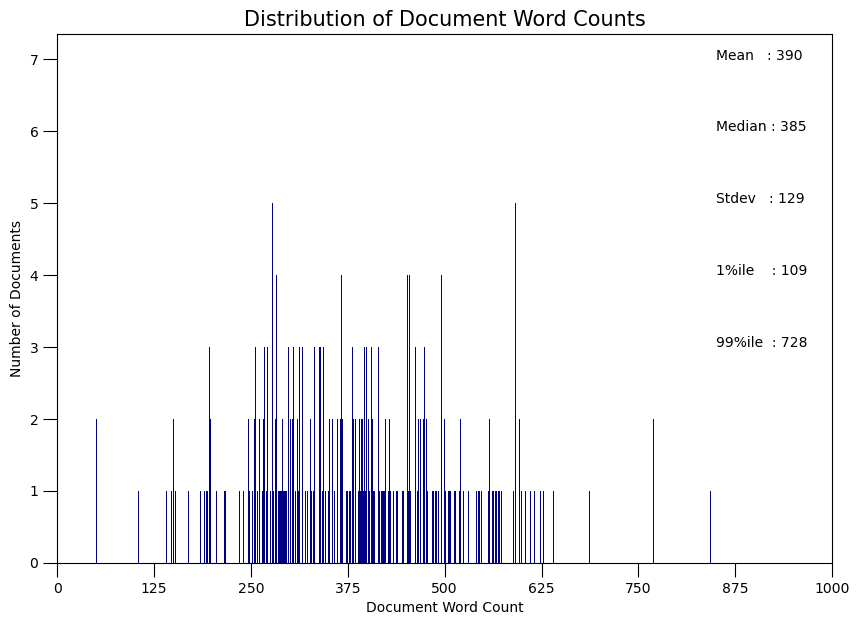

In [44]:
doc_lens = [len(d) for d in df_topic_sents_keywords.Text]

# Plot
plt.figure(figsize=(10,7), dpi=100)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(850, 7, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(850,  6, "Median : " + str(round(np.median(doc_lens))))
plt.text(850,  5, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(850,  4, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(850,  3, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=15))
plt.show()

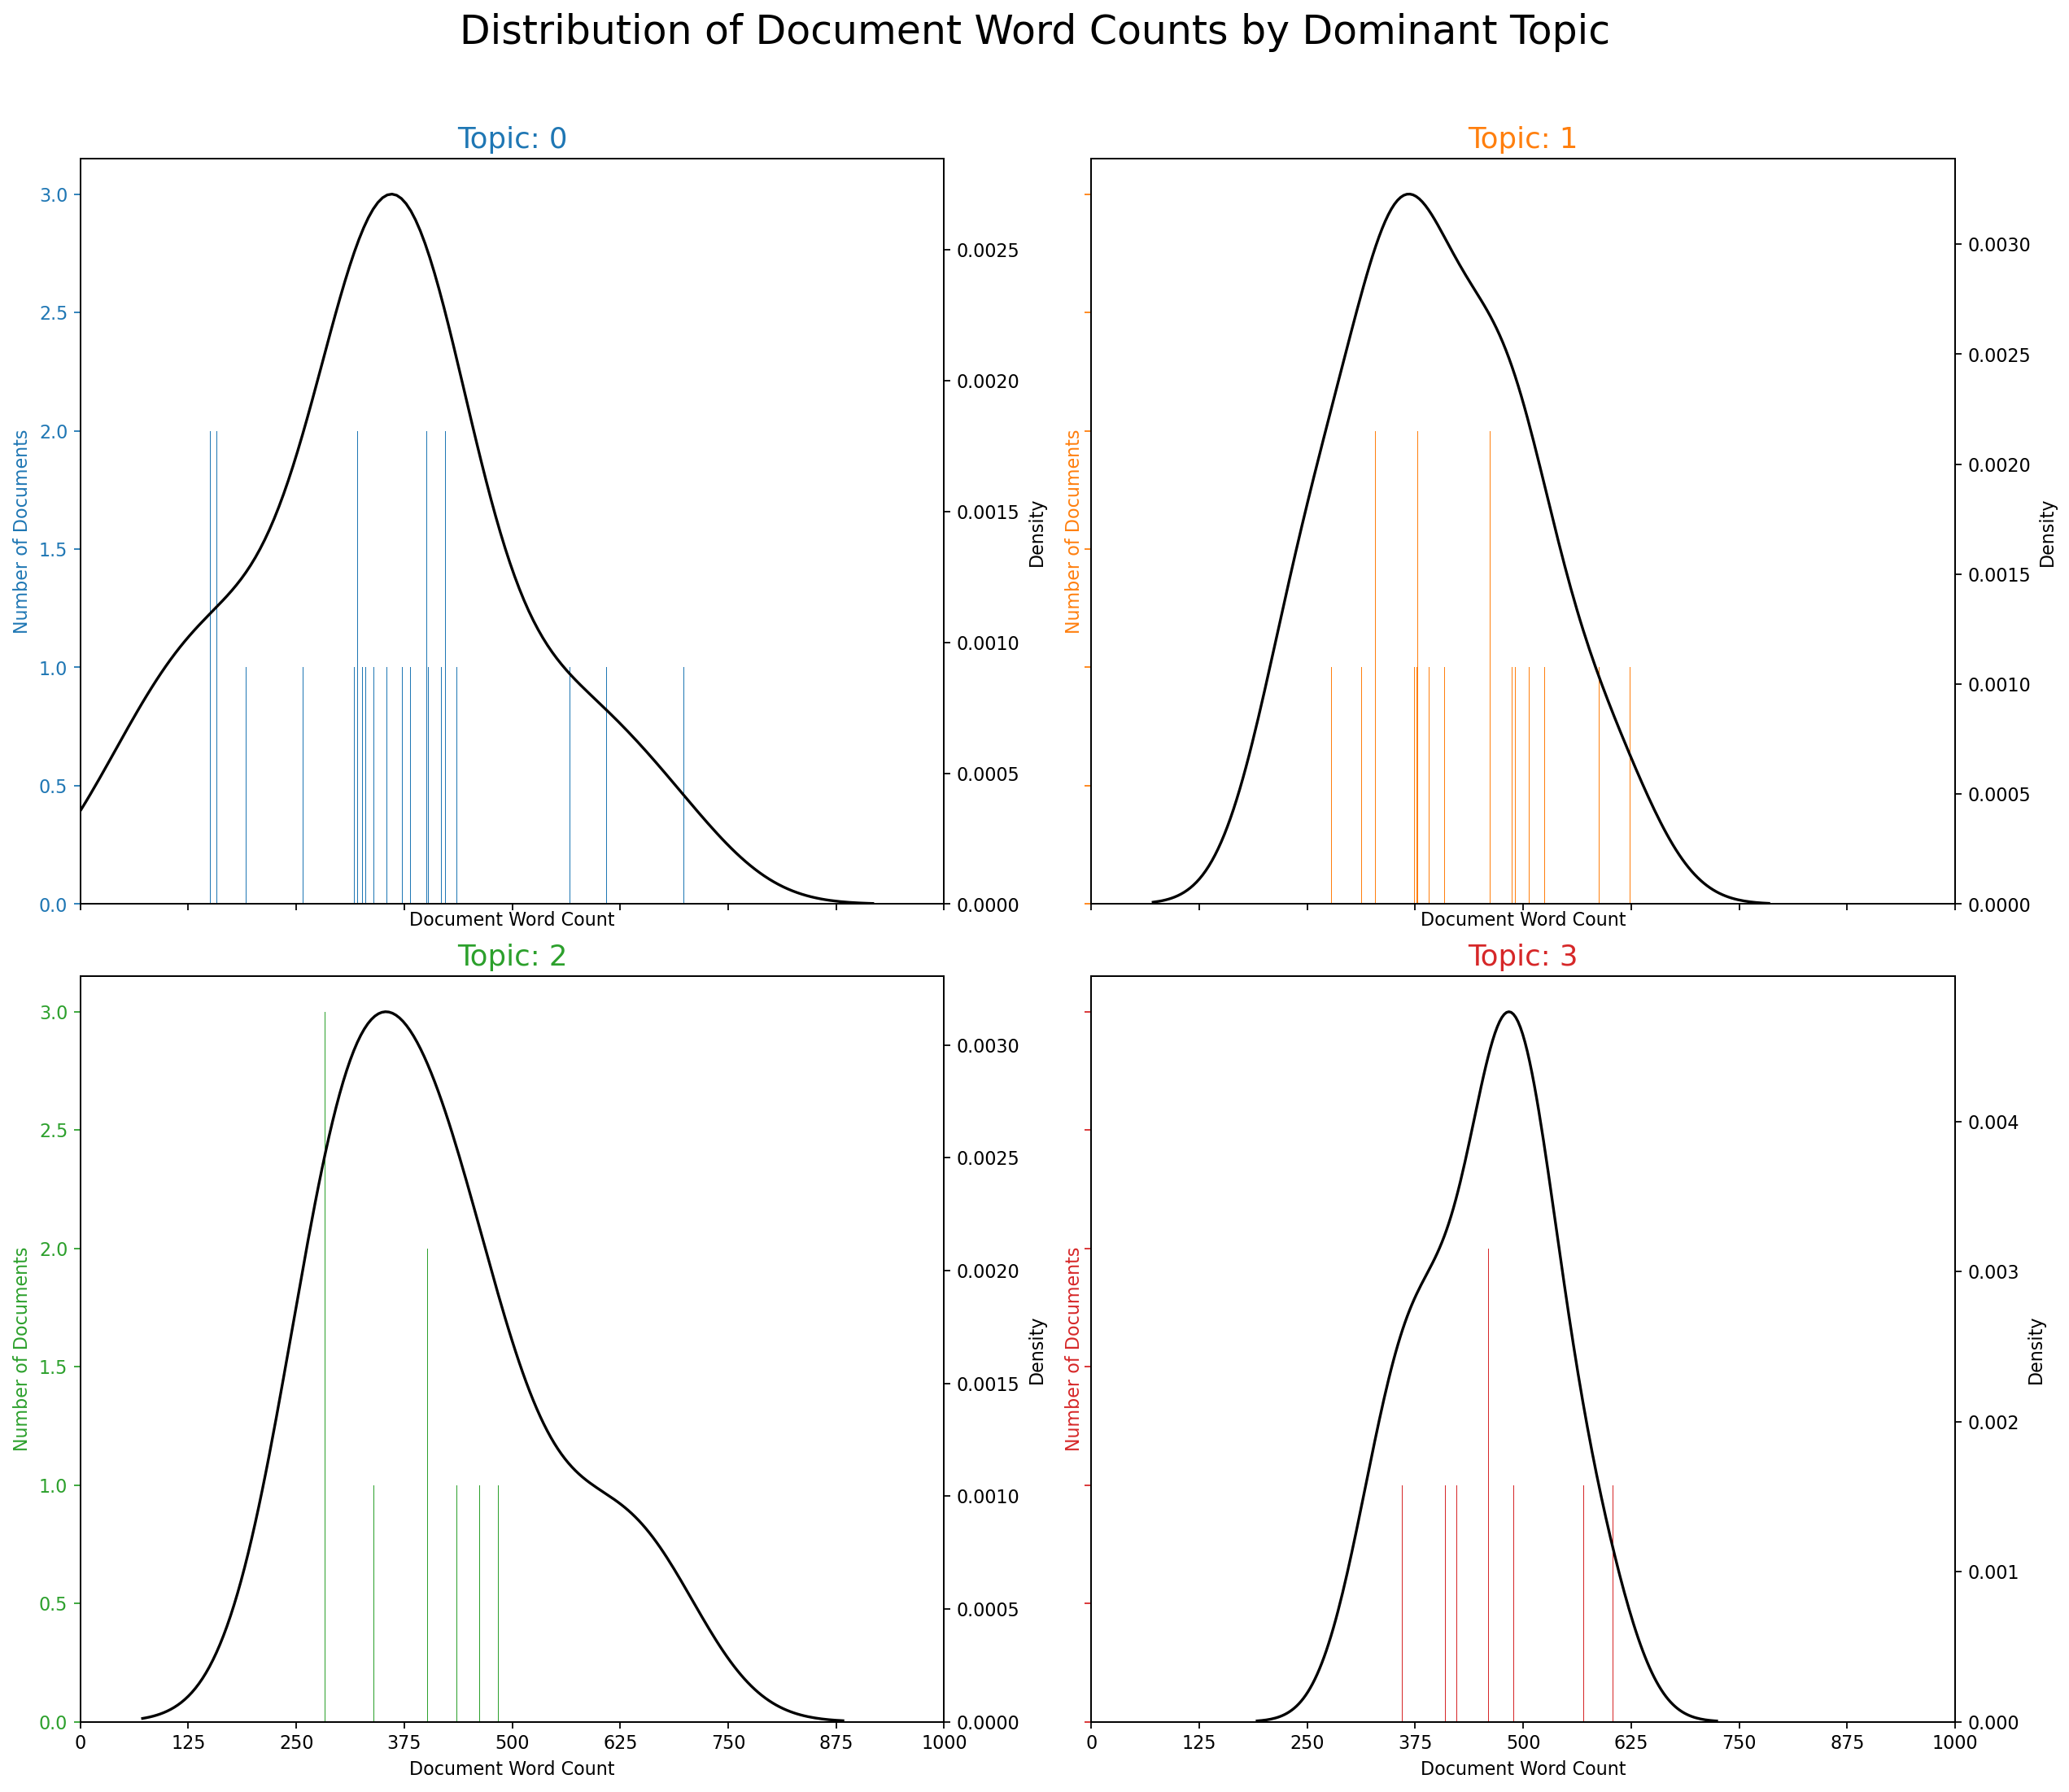

In [45]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_topic_sents_keywords.loc[df_topic_sents_keywords.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

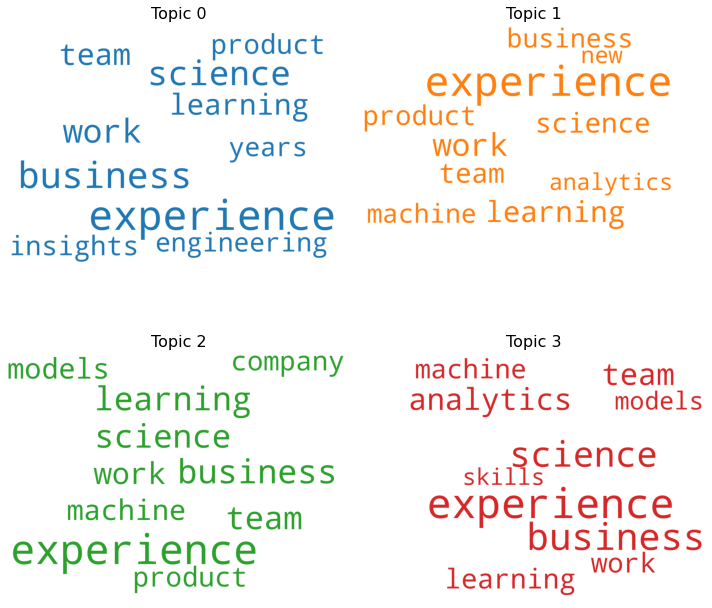

In [46]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords <a name="topic-keywords"></a>

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

<ipython-input-47-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-47-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-47-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-47-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


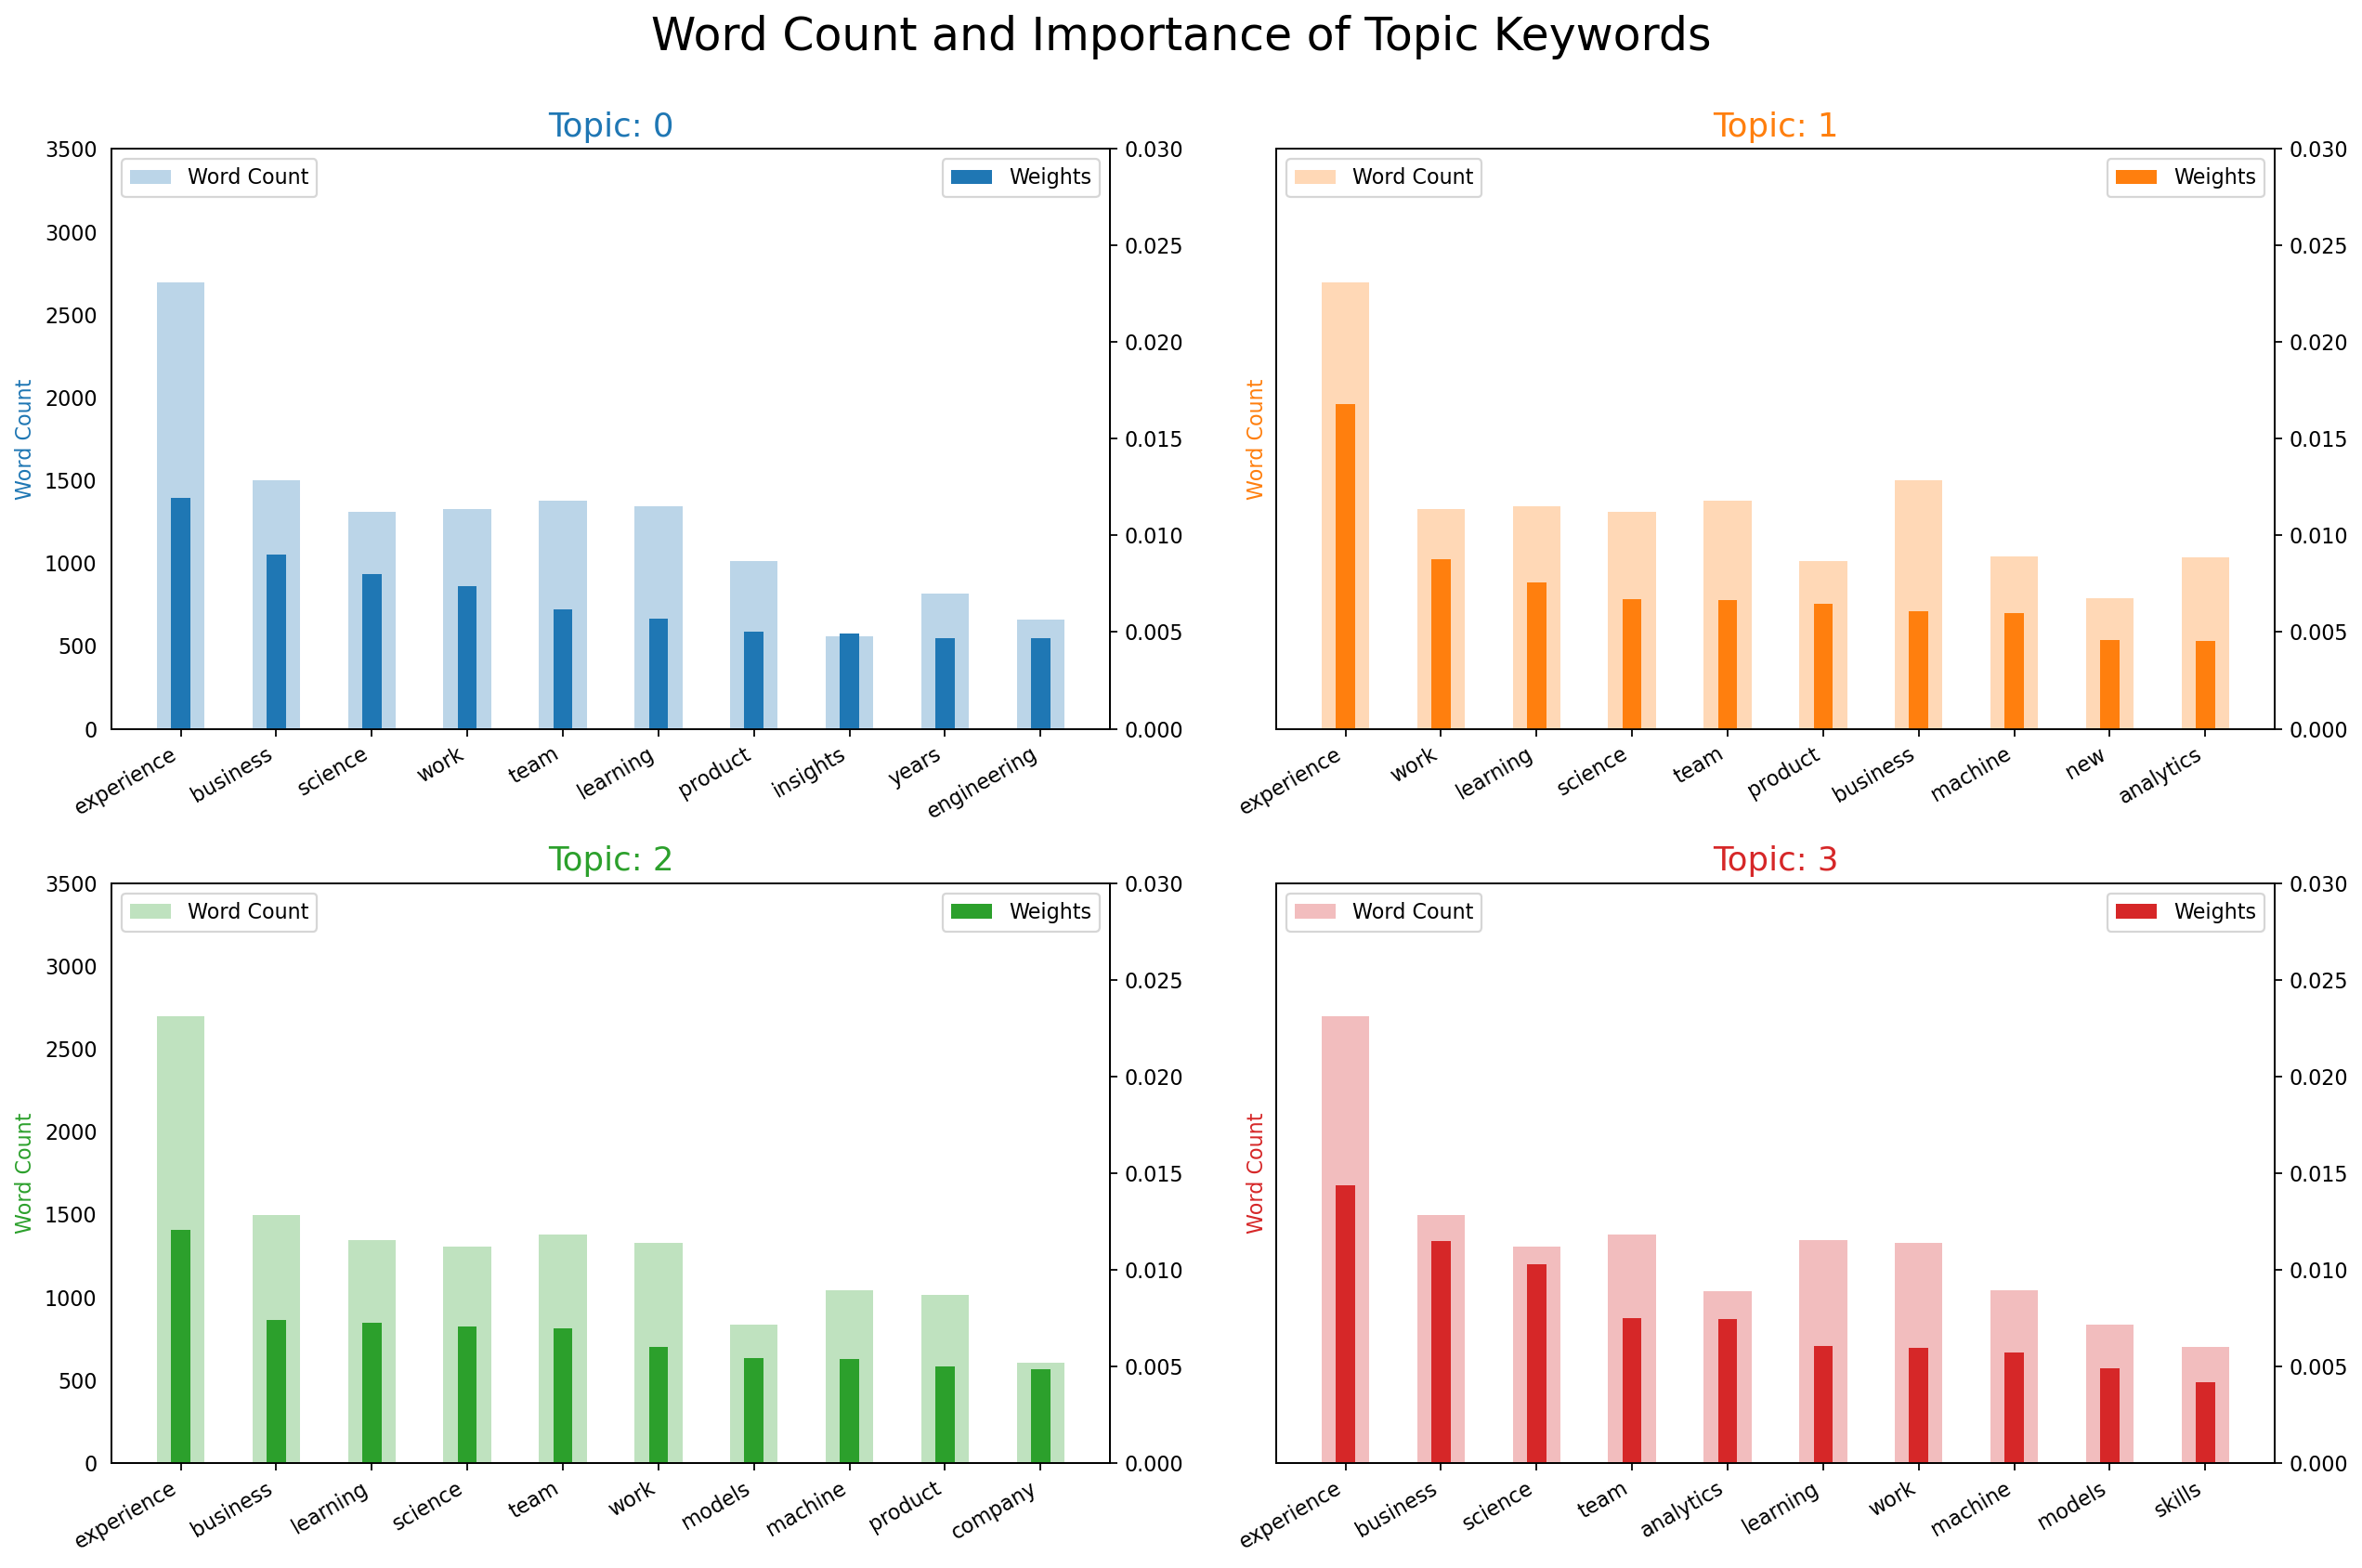

In [47]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# t-SNE Clustering Chart <a name="tsne"></a>
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [48]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 445 samples in 0.003s...
[t-SNE] Computed neighbors for 445 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 445 / 445
[t-SNE] Mean sigma: 0.000841
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.958885
[t-SNE] KL divergence after 1000 iterations: 0.207308


Loading BokehJS ...

In [55]:
from bokeh.io import export_png

export_png(plot, filename="tsne.png")

RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

# Python LDA Visualization (pyLDAvis) <a name="pyldavis"></a>

This is one of the coolest visualization tool we have for LDA. we can adjust $\lambda$ up or down to make it easier to see what each topic is talking about - so that we can see differences between clusters.

If you hover over individual words, you can also see which topics it is represented it as well.

Topics closer to each other have closer semantic representations.

An interactive visualization like pyLDAvis is essential for discovering topics.

In [49]:
# Note that the name of this function has been renamed - it is no longer gensim -- it is not gensim_models as for the newest version
import pyLDAvis.gensim_models

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [51]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.000915  0.005142       1        1  28.413953
5     -0.000554 -0.000081       2        1  16.409977
7     -0.013759 -0.004640       3        1  10.615658
0     -0.000136  0.011425       4        1   9.137187
8      0.002091 -0.001134       5        1   8.052593
1     -0.003210  0.003305       6        1   7.317909
3      0.004002 -0.005429       7        1   6.820812
6      0.005611 -0.001811       8        1   6.736443
2     -0.000327 -0.002493       9        1   3.696703
4      0.005367 -0.004284      10        1   2.798764, topic_info=           Term         Freq        Total Category  logprob  loglift
84   experience  2616.000000  2616.000000  Default  30.0000  30.0000
27     business  1420.000000  1420.000000  Default  29.0000  29.0000
198     science  1229.000000  1229.000000  Default  28.0000  28.0000
122    learning  1287.000000  1287.000000  Default  27.0000  27.0000
248        work  1267.000000  1267.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
393     working    17.156904   694.281231  Topic10  -5.6713  -0.1245
214  statistics    14.163287   497.490117  Topic10  -5.8630   0.0171
143         new    16.412685   767.898073  Topic10  -5.7156  -0.2696
271       build    15.468136   679.909581  Topic10  -5.7749  -0.2072
226   technical    14.246763   547.636733  Topic10  -5.8571  -0.0731

[853 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5460      2  0.533550      aaai
0         1  0.335625   ability
0         2  0.173168   ability
0         3  0.103544   ability
0         4  0.064269   ability
...     ...       ...       ...
251       8  0.063521     years
251       9  0.035425     years
251      10  0.026874     years
4254      1  0.345232  yugabyte
4254      4  0.345232  yugabyte

[2724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 1, 9, 2, 4, 7, 3, 5])

In [52]:
# Saving
pyLDAvis.save_html(vis, 'lda.html')

* What does it look like when we don't see the word data in there.
* Cut the number of words - we want more discriminatory power
* Because we are allowing there to be 10 tokens describing the topic. If we only have 4 or 5 words describing the topic, then we might be able to see a better distinction between the topics.
* 10 is an awfully big number of topics to pull out of the size of documents we have.
* We might want 3 or 4 topics
* 6 and 9 look like outliers so they might be for specific companies

Once we get interesting results - maybe like with 6 topics.

We want to see how many job postings are inside each topic. 

### Distribution of documents for each topic.

# Non-negative Matrix Factorization <a name="nmf"></a>

Now, I will try to apply a matrix factorization to the dataframe. We start by **reproducing** the documentation example:

In [201]:
# This matrix factorization function took a while... so I am trying to parallelize it
from numba import jit


Numba tends to work well with functions with a lot of loops and that involve numpy. Here's the [documentation](https://numba.pydata.org/numba-doc/latest/user/5minguide.html#will-numba-work-for-my-code)

In [202]:
@jit(nopython=True)
def matrix_factorization(R, P, Q, K, steps=5000, 
                alpha=0.0002, beta=0.02):
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * 
                                Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * 
                            eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) 
                                + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T

In [203]:
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)

N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
 
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)



In [204]:
print(R)
print("~~~~~~~~~~~~~~~~")
print(P)
print("~~~~~~~~~~~~~~~~")
print(Q)
print("~~~~~~~~~~~~~~~~")
print(nR)

[[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
~~~~~~~~~~~~~~~~
[[2.17261906 0.66658372]
 [1.69702655 0.6136545 ]
 [0.0377069  2.11290481]
 [0.06906816 1.69578466]
 [0.54651401 1.77677911]]
~~~~~~~~~~~~~~~~
[[ 2.15829343  0.47648858]
 [ 1.23131603  0.34605234]
 [ 1.63965977  2.24712829]
 [-0.26320101  2.3533428 ]]
~~~~~~~~~~~~~~~~
[[5.006769   2.90585353 5.0602552  0.99686448]
 [3.95508062 2.30193256 4.16150654 0.99748031]
 [1.08815757 0.77760476 4.80979464 4.96246483]
 [0.95709138 0.67187498 3.92389397 3.97258383]
 [2.02615257 1.28779003 4.88874764 4.03752729]]


In [188]:
#what about our group text example?


friend1 = "Machine learning is super fun"
friend2 = "Python is super, super cool"
friend3 = "Statistics is cool, too"
friend4 = "Fun? Data science is more than fun"
friend5 = "Python is great for machine learning"
friend6 = "I like football"
friend7 = "Football is great to watch"
textStr = [friend1, friend2, friend3, friend4, friend5, friend6, friend7]
print(textStr)




cvnorm = TfidfVectorizer(binary=False, stop_words='english', use_idf = False) #default is to normalize
cvnorm_dm = cvnorm.fit_transform(textStr)
print(cvnorm_dm.toarray())



['Machine learning is super fun', 'Python is super, super cool', 'Statistics is cool, too', 'Fun? Data science is more than fun', 'Python is great for machine learning', 'I like football', 'Football is great to watch']
[[0.         0.         0.         0.5        0.         0.5
  0.         0.5        0.         0.         0.         0.5
  0.        ]
 [0.40824829 0.         0.         0.         0.         0.
  0.         0.         0.40824829 0.         0.         0.81649658
  0.        ]
 [0.70710678 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.70710678 0.
  0.        ]
 [0.         0.40824829 0.         0.81649658 0.         0.
  0.         0.         0.         0.40824829 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.5        0.5
  0.         0.5        0.5        0.         0.         0.
  0.        ]
 [0.         0.         0.70710678 0.         0.         0.
  0.70710678 0.         0.         0.   

In [189]:
R = np.array(cvnorm_dm.toarray())

N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
 
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)
print(nR)

[[0.47861406 0.4961235  0.73914117 0.52932768 0.62206558 0.44448295
  0.54668247 0.4482464  0.4859455  0.3136534  0.56923868 0.55399355
  0.33292724]
 [0.52687779 0.37613682 0.73409487 0.65169174 0.53745446 0.53024215
  0.42578047 0.54027343 0.47135323 0.33347713 0.59317475 0.67812978
  0.36088608]
 [0.60133652 0.7636928  0.99436487 0.60810189 0.90320815 0.52465791
  0.83218035 0.52452524 0.6630491  0.40382382 0.74282657 0.63968279
  0.42292827]
 [0.61624223 0.4235456  0.85093457 0.76887579 0.61441028 0.62412326
  0.4810297  0.63642355 0.54516995 0.38890069 0.690558   0.79972909
  0.42155532]
 [0.49569561 0.37088821 0.69861214 0.60621973 0.52038962 0.49476456
  0.41819555 0.50361296 0.44982068 0.31492224 0.56141765 0.63116465
  0.3400895 ]
 [0.41626953 0.59789819 0.72074937 0.39285811 0.68524179 0.34651778
  0.64775715 0.34402792 0.48488868 0.28435093 0.52784384 0.41501093
  0.2950543 ]
 [0.46762996 0.39065991 0.67814182 0.555353   0.52625903 0.45693461
  0.4367309  0.46386997 0.439602

In [190]:
#transforms the matrix so that it can extract feature names that may apply to the topic in a document
# even if that feature name doesn't appear in that document.

#But you don't need to do the math directly
from sklearn.decomposition import NMF
n_topics = 3
n_top_words = 2

# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1).fit(cvnorm_dm)


names_texts = cvnorm.get_feature_names()

print(names_texts)



['cool', 'data', 'football', 'fun', 'great', 'learning', 'like', 'machine', 'python', 'science', 'statistics', 'super', 'watch']


In [191]:
print(type(nmf.components_))
print(len(nmf.components_))
print(nmf.components_)
text_components = nmf.components_

<class 'numpy.ndarray'>
3
[[0.         0.16521867 0.         0.66965112 0.21701335 0.58223715
  0.         0.58223715 0.30339442 0.16521867 0.         0.45984276
  0.        ]
 [0.         0.         0.78442041 0.         0.40568026 0.01598515
  0.42295974 0.01598515 0.03754171 0.         0.         0.
  0.36146067]
 [0.6775754  0.         0.         0.         0.         0.
  0.         0.         0.15622711 0.         0.48415424 0.33782021
  0.        ]]


In [192]:
# nice function for printing topic information - 
# https://stackoverflow.com/questions/34429635/topic-modelling-assign-a-document-with-top-2-topics-as-category-label-sklear

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

    

In [193]:
print("\nTopics for texts in NMF model:")
print_top_words(nmf, names_texts, n_top_words)


Topics for texts in NMF model:
Topic #0:
fun machine
Topic #1:
football like
Topic #2:
cool statistics



## Trying to Apply to My Dataset

In [3]:
# We start with our corpus
bow = nlp.to_wcdf(ds)

NameError: name 'nlp' is not defined

In [198]:
np.array(bow)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [205]:
%%time
R = np.array(bow)

N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)
print(nR)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
[[1.05679953 1.05077314 1.17195944 ... 1.7670503  0.97816851 1.54932701]
 [0.96992814 0.9421342  1.05101172 ... 1.55016847 0.86900043 1.40139913]
 [0.98842593 0.98360174 1.09703308 ... 1.65533778 0.91593161 1.44983802]
 ...
 [0.88756634 0.99549047 1.10918142 ... 1.84758574 0.96748725 1.40561337]
 [1.17472154 1.18797329 1.32478528 ... 2.02841172 1.1130897  1.74064037]
 [0.8483005  0.86763053 0.96745541 ... 1.49617743 0.81640353 1.26598506]]


In [207]:
bow

00  10  100  10000  100000  1100  12  13  15  15000  ...  write  writes  \
0     0   0    0      0       0     0   0   0   0      0  ...      0       0   
1     0   0    0      0       0     0   0   0   0      0  ...      0       0   
2     0   0    0      0       0     0   0   0   0      0  ...      0       0   
3     0   0    0      0       2     0   0   0   0      0  ...      0       0   
4     0   0    0      0       0     0   0   0   0      0  ...      0       0   
..   ..  ..  ...    ...     ...   ...  ..  ..  ..    ...  ...    ...     ...   
452   0   0    0      0       0     0   0   0   0      0  ...      0       0   
453   0   0    0      0       0     0   0   0   0      0  ...      1       0   
454   0   0    0      0       0     0   0   0   0      0  ...      0       0   
455   1   0    0      0       0     0   0   0   0      0  ...      0       0   
456   0   0    0      0       0     0   0   0   0      0  ...      0       0   

     writing  written  year  years  yes  yet  yield  york  
0          0        0     0      1    0    0      0     0  
1          0        0     0      1    0    0      0     0  
2          0        0     0      1    0    0      0     0  
3          0        0     0      3    0    0      0     2  
4          0        0     0      0    0    0      0     0  
..       ...      ...   ...    ...  ...  ...    ...   ...  
452        0        0     2      2    0    0      0     0  
453        0        0     0      2    0    0      0     0  
454        0        0     0      0    0    0      0     0  
455        0        1     0      3    0    0      0     1  
456        0        2     2      0    0    0      0     1  

[457 rows x 3412 columns]

In [233]:
#transforms the matrix so that it can extract feature names that may apply to the topic in a document
# even if that feature name doesn't appear in that document.

#But you don't need to do the math directly
from sklearn.decomposition import NMF
n_topics = 6
n_top_words = 5

# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1).fit(bow)


names_texts = bow.columns.tolist()

print(names_texts)

['00', '10', '100', '10000', '100000', '1100', '12', '13', '15', '15000', '16', '160', '18', '1873', '19', '1986', '1m', '20', '200', '2008', '2013', '2015', '2017', '2018', '2019', '2020', '2021', '24', '25', '250', '30', '31', '345', '40', '400', '401', '401k', '45', '50', '500', '5000', '600', '70', '90', 'ab', 'abilities', 'ability', 'able', 'abreast', 'absence', 'abstract', 'abundance', 'academia', 'academic', 'academics', 'accelerate', 'accelerating', 'accept', 'accepting', 'access', 'accessibility', 'accessible', 'accessing', 'accommodation', 'accommodations', 'accomplish', 'accordance', 'according', 'accordingly', 'account', 'accountabilities', 'accountable', 'accounting', 'accounts', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achievement', 'achieving', 'acquire', 'acquisition', 'across', 'act', 'action', 'actionable', 'actions', 'active', 'actively', 'activities', 'activity', 'actors', 'actual', 'acumen', 'ad', 'adapt', 'adapting', 'add', 'added', 'adding', 

In [234]:
print(type(nmf.components_))
print(len(nmf.components_))
print(nmf.components_)
text_components = nmf.components_

<class 'numpy.ndarray'>
6
[[0.         0.         0.11291096 ... 0.         0.0313402  0.13909554]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00879148 0.         ... 0.         0.         0.        ]
 [0.         0.07469013 0.06835741 ... 0.09658556 0.0104571  0.14494384]
 [0.1179367  0.15845473 0.09361084 ... 0.         0.         0.23709523]
 [0.         0.         0.01965461 ... 0.         0.         0.11099927]]


In [1]:
# nice function for printing topic information - 
# https://stackoverflow.com/questions/34429635/topic-modelling-assign-a-document-with-top-2-topics-as-category-label-sklear

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))



In [2]:
print("\nTopics for texts in NMF model:")
print_top_words(nmf, names_texts, n_top_words)


Topics for texts in NMF model:


NameError: name 'nmf' is not defined

It's interesting to see facebook pop up as a topic because facebook DOES know what data scientists do.

Industries pop up... but FB comes up to define a particular topic. 

If we did the same thing for data analytics, we might get completely different results. There might not be enough info in the postings to differentiate differnce in expectations between the two jobs. That's okay. This tells you that people writing these job descriptions are not doing well to advertise clearly what their expectations are. This may lead to a mismatch. This contributes to labor market churn beacuse we are always worrying about getting matches between worker and description.

LDA - using the distribution to portion things out

LSA - looking for a third latent variable to make a relationship

NMF - based on coming up with a way of partitioning out in the example the P Q peice of information. We can factor in the information into two different pieces and use that information to explain differences in different topics.


What is the information in the job posting that would let you know what kinds of skill expectations a particular company has.

Looking at the description of the person or the description of the job - more valuable. Is there a big difference between different kinds of jobs?

From a general topic model perspective, this kind of activity is often used like a classification technique. If I have news articles and I want to figure out how to process a bunch of info for people interested in certain things, then we can tag things based on these topics. It's a clustering idea, despite not being a clustering algorithm.

Are there differences in data literacy requirements between data anlyst and scientist, we would expect to see distinctions in the way they describe. This topic modeling is just another way to see how these distinctions are making themselves known. Is there enough information in the job descriptions to distinguish between data anlyst and scientist. We can make a matching function - how might this research help you find out which of these might be more appropriate.

Employer's perspective - if we want data work done, how do I write the job description to get people who have the right set of skills.

# Decision Tree and Random Forest

What are the things that are causing the tree to split?

If we ran it on the full vectorized dataframe, is there a couple of terms that actually pop up as having high discriminatory power. What are the feature importances list to help discriminate between my groups.